### Dog breed classification Inference

##### Import the necessary module

In [2]:
import torch
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import time
import json
import copy

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_on_gpu = torch.cuda.is_available()

train_dir = "dogs"
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.Resize(255), #square shape
                                transforms.CenterCrop(224), #square from the center of the image
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                     [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
classes = train_data.classes






model = models.resnet18(pretrained=True)


for param in model.parameters():
    param.requires_grad = False

n_inputs = model.fc.in_features

# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))
model.fc = last_layer

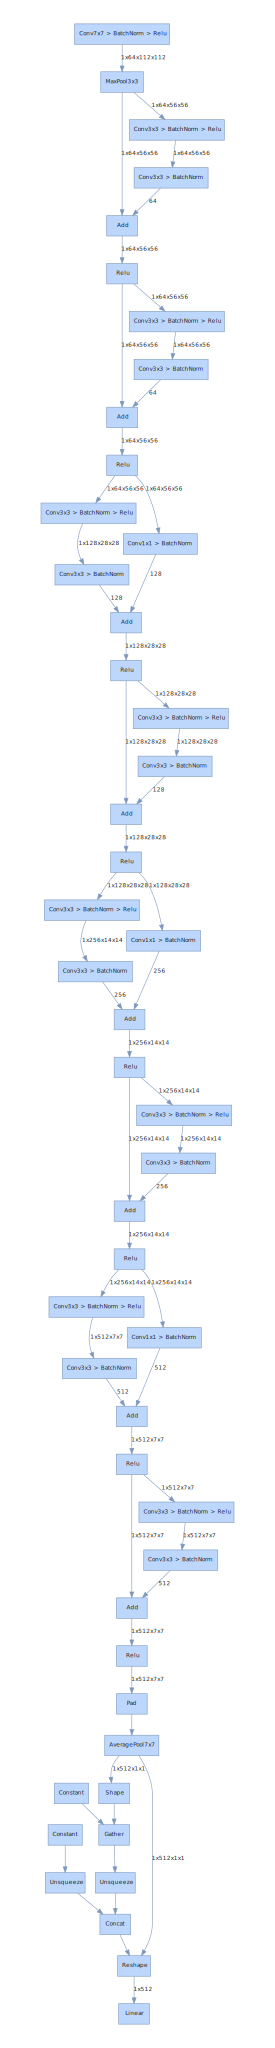

In [9]:
import hiddenlayer as hl

hl_graph = hl.build_graph(model, torch.zeros([1, 3, 224, 224]))
hl_graph.theme = hl.graph.THEMES["blue"].copy()
hl_graph

In [104]:
print("Model Loading...")
model.load_state_dict(torch.load('model.pt', map_location='cpu'))
#torch.load('model.pt', map_location=lambda storage, location: 'cpu')
print("Model succefully loaded !")
model.eval()

Model Loading...
Model succefully loaded !


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

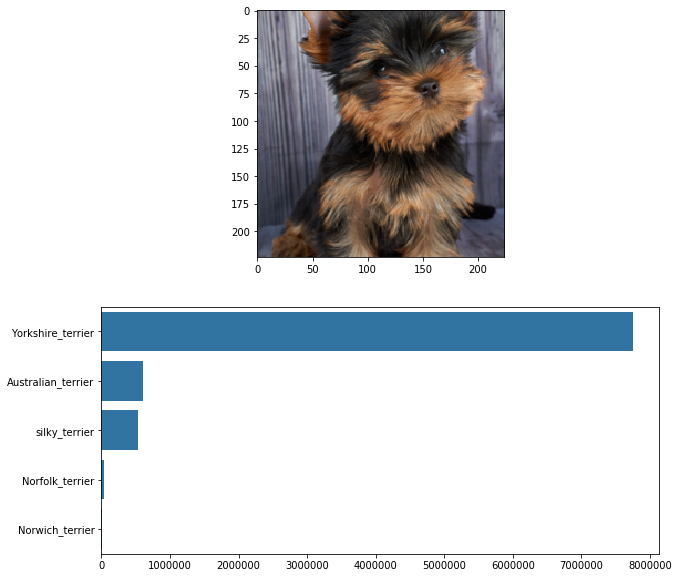

In [128]:
from PIL import Image
import numpy as np
import seaborn as sns

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img = Image.open(image)
    
    # Resize image
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
        
    # Crop image
    bottom_margin = (img.height-224)/2
    top_margin = bottom_margin + 224
    left_margin = (img.width-224)/2
    right_margin = left_margin + 224
    
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    
    # Normalize image
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img - mean)/std
    
    # move to first dimension --> PyTorch
    img = img.transpose((2, 0, 1))
    
    return img




def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax



def predict(image_path, model, imageFolderVariable, top_k=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    #process image
    img = process_image(image_path)
    #transform to tensor
    tensor_img = torch.from_numpy(img).type(torch.FloatTensor)
    #batch 1
    input_model = tensor_img.unsqueeze(0)

    # doesn't work on GPU, so I moved it to cpu
    model = model.cpu()
    log_results = model(input_model)
    proba = torch.exp(log_results)

    top_proba, top_label = proba.topk(top_k)
    top_proba = top_proba.detach().numpy().tolist()[0] 
    top_label = top_label.detach().numpy().tolist()[0]

    # transform indices to classes name
    idx_to_class = {val: key for key, val in imageFolderVariable.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_label]
    
    return top_proba, [i[10:] for i in top_labels]


def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (10,10))
    ax = plt.subplot(2,1,1)

    # Plot 
    img = process_image(image_path)
    imshow(img, ax);

    # Make prediction
    probs, labs = predict(image_path, model, train_data)

    # Plot bar chart
    
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=labs, color=sns.color_palette()[0]);
    plt.show()
    
plot_solution('yorkshire-terrier.jpg', model)

In [127]:
predict('yorkshire-terrier.jpg', model, train_data, top_k=1)[1][0]

'Yorkshire_terrier'